In [7]:
# Libraries
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import mysql.connector

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
def get_data(query):
    host = os.environ.get("MYSQL_HOST", "localhost")
    port = os.environ.get("MYSQL_PORT", "3306")
    dbname = os.environ.get("MYSQL_DBNAME", "test")
    user = os.environ.get("MYSQL_USER", "root")
    password = os.environ.get("MYSQL_PASSWORD", "")

    try:
        conn = mysql.connector.connect(
            host=host,
            port=port,
            user=user,
            password=password,
            database=dbname
        )
        if conn.is_connected():
            # Create a cursor
            cursor = conn.cursor()
            
            # Execute the query
            cursor.execute(query)
            
            # Fetch the results into a Pandas DataFrame
            result = cursor.fetchall()
            df = pd.DataFrame(result, columns=cursor.column_names)
            return df
        else:
            print("Connection to MySQL database failed.")
    except mysql.connector.Error as err:
        print(f"Error: {err}")

In [9]:
# Getting charger data from MySQL database with custom query
query = "SELECT canton, COUNT(*) AS count FROM charger_data_with_canton GROUP BY canton ORDER BY canton ASC"

# Get data from MySQL database
df_canton_count = get_data(query)
df_canton_count.loc[df_canton_count['canton'] == 'Fribourg', 'canton'] = 'Freiburg'

query = "SELECT * FROM canton_data ORDER By canton ASC"

df_canton_data = get_data(query)

print(df_canton_count)
print(df_canton_data)

# Merge dataframes
df = pd.merge(df_canton_data, df_canton_count, on='canton')

df

                    canton  count
0                   Aargau    920
1   Appenzell Ausserrhoden     54
2    Appenzell Innerrhoden     24
3         Basel-Landschaft    362
4              Basel-Stadt    229
5                     Bern   1196
6                 Freiburg    378
7                     Genf    686
8                   Glarus     91
9               Graubünden    711
10                    Jura     71
11                  Luzern    706
12               Neuenburg    241
13               Nidwalden     81
14                Obwalden     69
15            Schaffhausen    128
16                  Schwyz    246
17               Solothurn    310
18              St. Gallen    842
19                  Tessin    705
20                 Thurgau    284
21                     Uri    103
22                   Waadt   1080
23                  Wallis    879
24                     Zug    378
25                  Zürich   1716
                    canton abbreviation  popDens  medianIncome  inhabitants  \
0  

,canton,abbreviation,popDens,medianIncome,inhabitants,rural,count
0,Aargau,AG,509.8,75391,711232,1,920
1,Appenzell Ausserrhoden,AR,229.6,71911,55759,1,54
2,Appenzell Innerrhoden,AI,95.2,84535,16416,1,24
3,Basel-Landschaft,BL,568.7,77061,294417,1,362
4,Basel-Stadt,BS,5325.7,78200,196786,0,229
5,Bern,BE,180.1,74886,1051437,1,1196
6,Freiburg,FR,210.1,71996,334465,1,378
7,Genf,GE,2091.6,77001,514114,0,686
8,Glarus,GL,60.9,72860,41471,1,91
9,Graubünden,GR,28.5,70130,202538,1,711


In [10]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df['inhabitants'], 
                                                    df['count'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
13      44420
1       55759
23     357282
5     1051437
2       16416
Name: inhabitants, dtype: int64 

y_train:
13      81
1       54
23     879
5     1196
2       24
Name: count, dtype: int64


In [11]:
# Fit the regression model
slope, intercept, r, p, std_err = stats.linregress(X_train, y_train)

# Print results of the regression model
print('Linear regression result:')
print(f'Intercept with y-axis (alpha):            {intercept:.2f}')
print(f'Slope of regression line (beta):          {slope:.3f}')
print(f'p-value:                                  {p:.4f}')
print(f'R-squared (coefficient of determination): {r**2:.4f}')

Linear regression result:
Intercept with y-axis (alpha):            68.87
Slope of regression line (beta):          0.001
p-value:                                  0.0000
R-squared (coefficient of determination): 0.9196


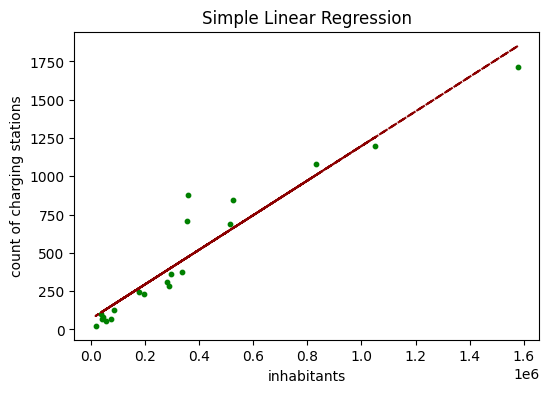

In [12]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, s=10, color='green')
plt.plot(X_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('inhabitants')
plt.ylabel('count of charging stations')

plt.show()

# Interpretation
So if we look at the given values of the regression, we can see, that we have a p-value of 0.0000 which for us means, that our statistics are statistically relevant. Also our r-squared value is 0.9194, which means, that 91.94% of all chargingstations can be explained through the amount of inhabitant in a canton. Our beta is 0.001 which can interpreted as: If there is one more inhabitant, there would have to be 0.001 more chargingstation.


In [13]:
# Calculate model residuals for train data
print(mymodel)
print(y_train)
residuals = y_train - mymodel
print(residuals)

# Check the first residual value in our data set
print(f'1st Predicted price in dataset: {mymodel.iloc[0]:.2f}')
print(f'1st Observed price in dataset: {y_train.iloc[0]:.2f}')
print(f'1st Residual price in dataset: {residuals.iloc[0]:.2f}')

0      119.023802
1      131.826187
2      472.263048
3     1256.004088
4       87.405670
5      268.229905
6      165.082581
7      401.284837
8      291.053806
9      111.004105
10     387.725983
11    1006.475565
12     662.718145
13    1852.744949
14     395.902619
15     649.335424
16     152.268906
17     112.565592
18     468.583449
19     446.501339
dtype: float64
13      81
1       54
23     879
5     1196
2       24
12     241
15     128
3      362
4      229
21     103
17     310
22    1080
18     842
25    1716
20     284
7      686
10      71
14      69
19     705
6      378
Name: count, dtype: int64
0             NaN
1      -77.826187
2     -448.263048
3     -894.004088
4      141.594330
5      927.770095
6      212.917419
7      284.715163
8             NaN
9             NaN
10    -316.725983
11            NaN
12    -421.718145
13   -1771.744949
14    -326.902619
15    -521.335424
16            NaN
17     197.434408
18     373.416551
19     258.498661
20            NaN
2

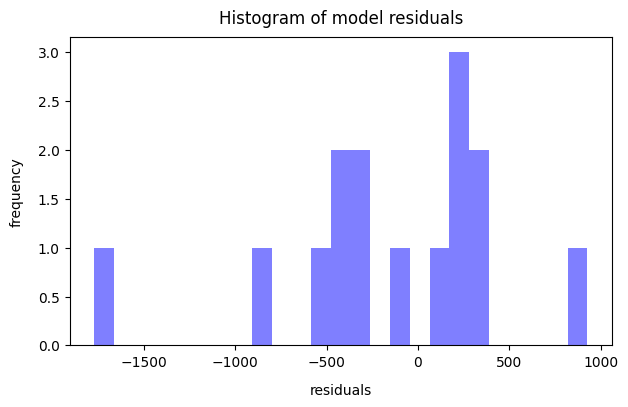

In [14]:
# Plot histogram of residuals
fig = plt.figure( figsize=(7,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set title and labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

# Show plot
plt.show()

In [15]:
# Create model predictions for test data
predicted = myfunc(X_test)
predicted.round(1)

# Get the minimum length of y_test and predicted
min_length = min(len(y_test), len(predicted))

# Compare the observed prices with the predicted prices
for i in range(min_length):
    print(f'Observed count of chargers: {y_test.iloc[i]:.1f}, Predicted count of chargers: {predicted.iloc[i]:.1f}')

Observed count of chargers: 91.0, Predicted count of chargers: 115.7
Observed count of chargers: 246.0, Predicted count of chargers: 255.1
Observed count of chargers: 920.0, Predicted count of chargers: 871.9
Observed count of chargers: 378.0, Predicted count of chargers: 217.0
Observed count of chargers: 706.0, Predicted count of chargers: 548.6
Observed count of chargers: 711.0, Predicted count of chargers: 297.5


# Now we want to check how the regressoin looks without the urban cantons
We define urban as cantons with a popDens higher than 900

In [26]:
# Write query that gets canton_data where rural is true
query = "SELECT * FROM canton_data WHERE rural = TRUE ORDER BY canton ASC"

df_canton_data = get_data(query)

# Merge dataframes
df_rural = pd.merge(df_canton_data, df_canton_count, on='canton')

df_rural

,canton,abbreviation,popDens,medianIncome,inhabitants,rural,count
0,Aargau,AG,509.8,75391,711232,1,920
1,Appenzell Ausserrhoden,AR,229.6,71911,55759,1,54
2,Appenzell Innerrhoden,AI,95.2,84535,16416,1,24
3,Basel-Landschaft,BL,568.7,77061,294417,1,362
4,Bern,BE,180.1,74886,1051437,1,1196
5,Freiburg,FR,210.1,71996,334465,1,378
6,Glarus,GL,60.9,72860,41471,1,91
7,Graubünden,GR,28.5,70130,202538,1,711
8,Jura,JU,88.1,65000,73865,1,71
9,Luzern,LU,297.3,73678,424851,1,706


In [27]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df_rural['inhabitants'], 
                                                    df_rural['count'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
12     38700
1      55759
13     85214
5     334465
2      16416
Name: inhabitants, dtype: int64 

y_train:
12     69
1      54
13    128
5     378
2      24
Name: count, dtype: int64


In [28]:
# Fit the regression model
slope, intercept, r, p, std_err = stats.linregress(X_train, y_train)

# Print results of the regression model
print('Linear regression result:')
print(f'Intercept with y-axis (alpha):            {intercept:.2f}')
print(f'Slope of regression line (beta):          {slope:.3f}')
print(f'p-value:                                  {p:.4f}')
print(f'R-squared (coefficient of determination): {r**2:.4f}')

Linear regression result:
Intercept with y-axis (alpha):            86.26
Slope of regression line (beta):          0.001
p-value:                                  0.0000
R-squared (coefficient of determination): 0.8298


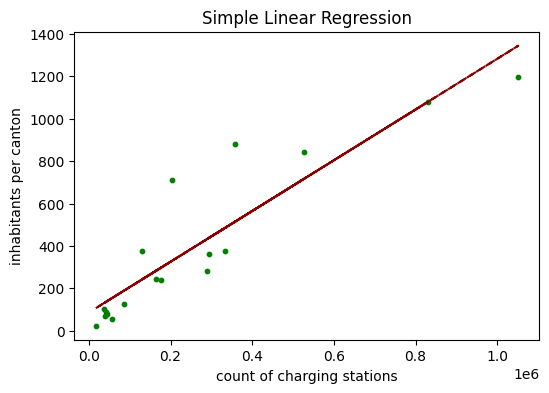

In [29]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, s=10, color='green')
plt.plot(X_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('count of charging stations')
plt.ylabel('inhabitants per canton')

plt.show()

In [30]:
# Calculate model residuals for train data
print(mymodel)
print(y_train)
residuals = y_train - mymodel
print(residuals)

# Check the first residual value in our data set
print(f'1st Predicted price in dataset: {mymodel.iloc[0]:.2f}')
print(f'1st Observed price in dataset: {y_train.iloc[0]:.2f}')
print(f'1st Residual price in dataset: {residuals.iloc[0]:.2f}')

0      132.543301
1      152.942865
2      188.165866
3      486.226238
4      105.895555
5      139.383415
6     1079.314370
7      438.335871
8     1343.598687
9      432.635377
10     715.228959
11     513.511358
12     243.113987
13     328.464742
14     297.412775
15     283.480228
16     130.889476
17     135.856930
dtype: float64
12      69
1       54
13     128
5      378
2       24
11      81
20    1080
3      362
4     1196
18     284
16     842
21     879
22     378
7      711
10     241
14     246
19     103
6       91
Name: count, dtype: int64
0             NaN
1      -98.942865
2     -164.165866
3     -124.226238
4     1090.104445
5      238.616585
6     -988.314370
7      272.664129
8             NaN
9             NaN
10    -474.228959
11    -432.511358
12    -174.113987
13    -200.464742
14     -51.412775
15            NaN
16     711.110524
17            NaN
18            NaN
19            NaN
20            NaN
21            NaN
22            NaN
dtype: float64
1st Pred

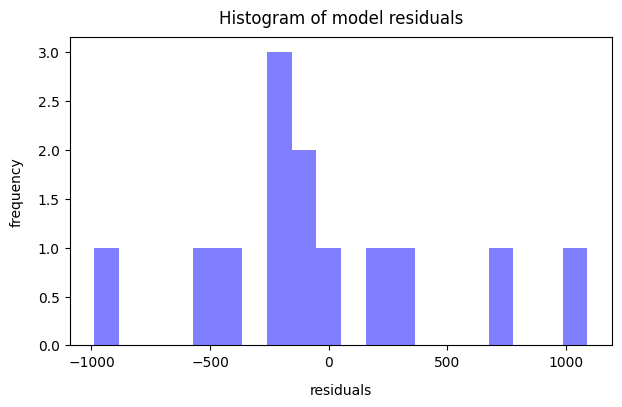

In [33]:
# Plot histogram of residuals
fig = plt.figure( figsize=(7,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=20, 
                            color='blue',
                            alpha=0.5
                   )

# Set title and labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

# Show plot
plt.show()

In [34]:
# Create model predictions for test data
predicted = myfunc(X_test)
predicted.round(1)

# Get the minimum length of y_test and predicted
min_length = min(len(y_test), len(predicted))

# Compare the observed prices with the predicted prices
for i in range(min_length):
    print(f'Observed count of chargers: {y_test.iloc[i]:.1f}, Predicted count of chargers: {predicted.iloc[i]:.1f}')

Observed count of chargers: 310.0, Predicted count of chargers: 424.0
Observed count of chargers: 706.0, Predicted count of chargers: 594.3
Observed count of chargers: 920.0, Predicted count of chargers: 936.8
Observed count of chargers: 71.0, Predicted count of chargers: 174.6
Observed count of chargers: 705.0, Predicted count of chargers: 509.6
